# Punto 1 y 2

Comentado en PDF

# Punto 2 y 4

Importamos las librerías que vamos a utilizar

In [1]:
from datetime import datetime

import numpy as np

import matplotlib.pyplot as plt
from matplotlib import gridspec

import pandas as pd

import seaborn as sns
import  shutil, os

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler

from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input



Cargamos el dataset un pandas dataframe y ya escalamos todas las imágenes a un tamaño determinado

In [2]:
img_folder = 'imgs'
label_folder = 'label'

def image_df(path, image_size=(256,256), extension= '.jpg'):
    """
    Función que vuelva el contenido completo de un directorio con imágenes en un dataset.i
    Información por columnas: 
        path: ruta original del archivo.
        file: nombre del archivo.
        image_original_size: imagen original.
        image: imagen escalada.
        size: tamaño original de la imagen.

    Args:
        path (str): ruta del directorio a volcar
        image_size (tuple, optional): tamaño de imagen normalizada. Defaults to (256,256).

    Returns:
        Pandas dataframe.
    """
    
    file_names = os.listdir(path)
    images = [{ 'path': os.path.abspath(os.path.join(img_folder,f)),
                'file': f, 
                'image_original_size': image.load_img(os.path.join(img_folder,f)),
                'image': image.load_img(os.path.join(img_folder,f), target_size=image_size),
                'size': image.load_img(os.path.join(img_folder,f)).size
                 } for f in file_names if f .endswith(extension)]
    return pd.DataFrame(images)


In [3]:
image_size= (200,200)
df = image_df(os.path.join('.',img_folder), image_size= (200,200))

Efectivcamente las imágenes originales tienen diferentes tamaño

In [4]:
df['size'].sample(7)

164     (240, 236)
1308    (500, 333)
486     (320, 240)
294     (240, 159)
1397    (240, 160)
321     (500, 375)
219     (500, 333)
Name: size, dtype: object

Creamos una función para visualizar imágenes aleatorias del dataset

In [5]:
def print_flowers(df, num_examples = 9, col='image', size = (15,10)):
    """
    Función que imprime por consola un número imágenes aleatoriamente escogidas de un Pandas dataframe.

    Args:
        df (Pandas dataframe): Dataframe contenedor de imágenes
        num_examples (int, optional): Número de imágenes a mostrar. Defaults to 9.
        col (str, optional): Nombre de la columna que contiene las imágenes. Defaults to 'image'.
        size (tuple, optional): Tamaño de la figura que contiene las imágenes. Defaults to (15,10).

    Returns: None
    """
    
    try:
        num_imgs_df = df.shape[0]
        num_imgs_show = min(num_examples, num_imgs_df)
        
        print("Número de imágenes: ", num_imgs_df)

        df_examples = df.sample(num_imgs_show)
        gs = gridspec.GridSpec(int(np.ceil(np.sqrt(num_imgs_show))), int(np.ceil(np.sqrt(num_imgs_show))))
        plt.figure(figsize = size)

        for i in range(0, num_imgs_show):
            plt.subplot(gs[i])
            plt.imshow(df_examples.reset_index()[col][i])    
            plt.axis('off')
    except Exception as e:
        print("Ha surgido un problemaal imprimir")
        print(e)


Imprimimos imágenes del dataset

Número de imágenes:  1567


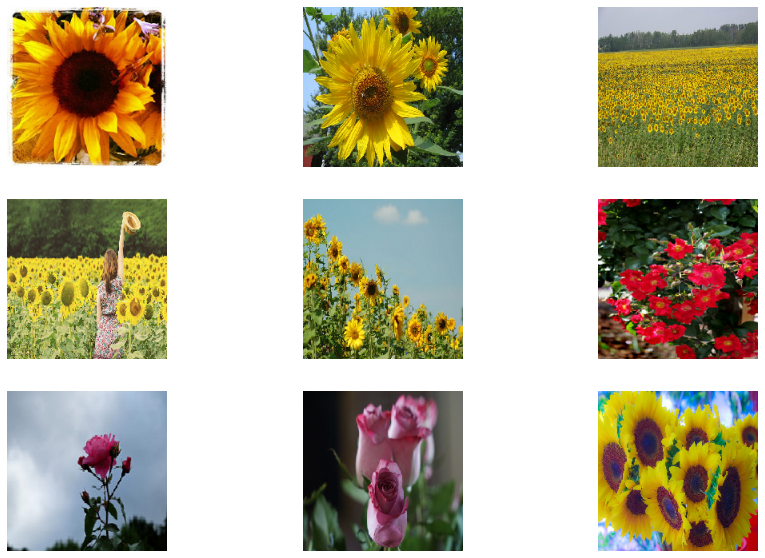

In [6]:
print_flowers(df)

A cada una de estas imágenes le extraemos las features mediante una red preentrenada para imágens. La escogida, por su simplicidad a pesar de haber ganado ImageNet 2012 es la ResNet50. Esta librería preentrenada con imágenes nos permitirá extraer features para nuestro clasificador. Uitlizamos parámetro  de pesos 'imagenet' (pre-entrenamiento con ImageNet) y no incluímos las capas clasificadoras. 

In [7]:
model = ResNet50(weights='imagenet', include_top=False, input_shape= (image_size[0],image_size[1],3));

2021-10-19 12:14:20.682155: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Extraemos todas las feautres de cada imagen

In [8]:
def extract_features(img, model):
    """Función que extrae las features de una imagen.

    Args:
        img (Image): Imagen a extraer features
        model (Keras engine): Modelo con el que extraer las variables.

    Returns:
        [Numpy array]: Array con todas las features de la imagen.
    """
    x = image.img_to_array(img)
    y = np.expand_dims(x, axis=0)
    z = preprocess_input(y)
    return model.predict(z,  batch_size=32).flatten()


In [9]:
df['features']= df.image.apply(lambda x: extract_features(x,model)) #No he conseguido hacerlo vectorizado con numpy y me he decantado por hacerlo con un apply a sabiendas de lo eficiente que sería en numpy

2021-10-19 12:14:21.820786: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


In [10]:
print("El vector que obtenemos es de longitud: ", df.loc[0,'features'].shape[0])

El vector que obtenemos es de longitud:  100352


Podemos utilizar “Análisis de Componentes Principales” o PCA para dereeducir el número de variables ya que una imagen existe mucha información redundante.

Lo primero que haremos será calcular la varianza que permanece a pesar de esta reducción.

In [11]:
max_features = 1500 #Ploteamos un máximo de 1500 variables
pca = PCA(n_components = max_features)
pca.fit(df['features'].to_list())
var=np.cumsum(pca.explained_variance_ratio_)

Pediremos mantener cierta varianza para no perder demasiada información en este proceso.

In [12]:
var_min = 0.8
n_features = next(x[0] for x in enumerate(var) if x[1] > var_min)
print(f'Mantenemos {n_features} variables')

Mantenemos 694 variables


Podemos ver como evoluciona la varianza tras el PCA en funcíon del número de variables:

Text(0, 0.5, '% variance')

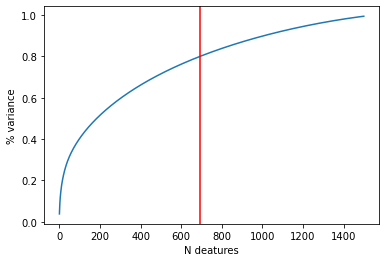

In [13]:
plt.plot(var)
plt.axvline(x=n_features, c='r')

plt.xlabel("N deatures")
plt.ylabel("% variance")

Aplicamos a nuestro array de features el PCA.

In [14]:
pca = PCA(n_components = n_features)
pca.fit(df['features'].to_list())

PCA(n_components=694)

In [15]:

df['features_pca'] = pca.transform(df['features'].tolist()).tolist()

Hemos guardado esta información en una sola columna, desplegamos por comodidad este array a columnas.

Nombramos las columnas:

In [16]:
pca_columns= ["pca_" + str(i+1) for i in range(n_features)]

Desplegamos las variables en las columnas del dataframe:

In [17]:
for i, r in df.iterrows():
    df.loc[i, pca_columns]=r['features_pca'] #seguramente haya un código mucho más eficiente que hacerlo con este for

Y este sería el PD con el que vamos a trabajar:

In [18]:
df.sample(3)

path            file  \
716  /Users/emilio/Trabajo/komorebi/imgs/imagen388.jpg   imagen388.jpg   
192  /Users/emilio/Trabajo/komorebi/imgs/imagen128.jpg   imagen128.jpg   
93   /Users/emilio/Trabajo/komorebi/imgs/imagen1316...  imagen1316.jpg   

                                   image_original_size  \
716  <PIL.JpegImagePlugin.JpegImageFile image mode=...   
192  <PIL.JpegImagePlugin.JpegImageFile image mode=...   
93   <PIL.JpegImagePlugin.JpegImageFile image mode=...   

                                                 image        size  \
716  <PIL.Image.Image image mode=RGB size=200x200 a...  (240, 167)   
192  <PIL.Image.Image image mode=RGB size=200x200 a...  (240, 159)   
93   <PIL.Image.Image image mode=RGB size=200x200 a...  (500, 331)   

                                              features  \
716  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
192  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
93   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                          features_pca      pca_1      pca_2  \
716  [70.53175077693432, -45.6067633308307, 9.93997...  70.531751 -45.606763   
192  [46.62331170763901, -25.786327049030326, 58.17...  46.623312 -25.786327   
93   [-93.35349858185265, 48.88284914105227, 21.449... -93.353499  48.882849   

         pca_3  ...    pca_685    pca_686    pca_687   pca_688    pca_689  \
716   9.939979  ...  13.563341  16.558470  -7.053607 -6.816296  12.140889   
192  58.176819  ...  11.038807  -9.282746 -12.575707  8.733210  -2.240257   
93   21.449636  ...  -4.062129  -1.536885   4.258024 -8.791347   2.091073   

      pca_690    pca_691    pca_692   pca_693   pca_694  
716  7.364561 -23.466994   3.204964 -4.270697 -6.032531  
192 -6.906131   3.944727  -6.704260 -2.467664  6.001200  
93  -5.410219   8.842036  10.369423 -0.235558 -1.853584  

[3 rows x 701 columns]

# Clusterización

Una vez extraidas las features y reducido su número con el PCA podemos comenzar a clusterizar

Para clusterizar elegimos el algoritmo de K means por ser el más habitual en la literatura para clusterización de imágenes. Las características fundamentales de este algoritmo son: es de propósito general, tamaño de clúster uniforme, geometría plana, no demasiados clusters, inductivo.

Vamos a determinar el número de clusters mediante el método elbow

In [19]:
def print_k(x, ini=1, end=20):
    """ Función para imprimir la SSE por cada número de cluster.
    Args:
        x (Numpy array): Numpy array de puntos
        ini (int, optional): num_de cluster inicial. Defaults to 1.
        end (int, optional): num de cluster final. Defaults to 20.
    """
    sse = {}
    
    for k in range(ini, end+1):
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(x)
        sse[k] = kmeans.inertia_

    import matplotlib.pylab as plt
    plt.plot(list(sse.keys()), list(sse.values()))
    plt.xlabel('k')
    plt.ylabel('SEE')
    plt.title('Curva K')
    plt.show()    

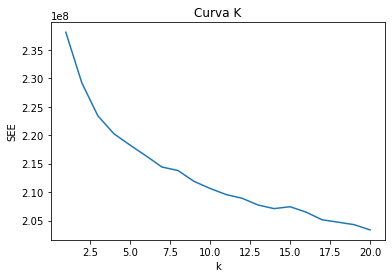

In [20]:
print_k(df[pca_columns])

Montamos el modelo de kmeans con el número de cluster igual a 5. Esto es un número mayor que las clases a diferenciar pero parece sensato intentar encontrar subgrupos dentro de las imágenes de girasoles y rosas, además de una tercera clase que sería "desconocido" (ya que hay muchas imágenes que no son ni girasoles ni rosas)

In [21]:
k =5
kmeans = KMeans(n_clusters = k)

Asignamos a cada imagen su etiqueta.

In [22]:
df['labels_kmeans'] = kmeans.fit_predict(df[pca_columns])

Text(0, 0.5, 'Count')

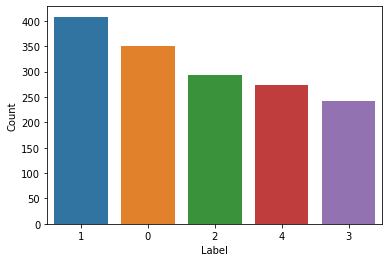

In [23]:
sns.countplot(x=df['labels_kmeans'], order = df['labels_kmeans'].value_counts().index)
plt.xlabel("Label")
plt.ylabel("Count")

In [24]:
df.labels_kmeans.value_counts()

1    408
0    351
2    293
4    273
3    242
Name: labels_kmeans, dtype: int64

# Enriquecimiento Dataset

Obtenemos los centroides:

In [25]:
centroids = kmeans.cluster_centers_

df_centroides = pd.DataFrame(centroids)
df_centroides.columns = pca_columns
df_centroides

pca_1      pca_2      pca_3      pca_4     pca_5      pca_6     pca_7  \
0   60.288987   6.600721  63.029524   8.634419 -9.723625   8.015484  3.447104   
1  -74.482309  84.952337 -14.892409  -3.553823  2.375548  -6.787633  0.121922   
2  -84.433226 -81.924619  19.414962  -8.834681  3.995035  21.505796  0.657957   
3   10.249301 -57.989053 -49.393872  50.377823 -3.105057 -33.956895 -0.843970   
4  115.333158   3.882262 -35.833431 -40.965541  7.416291   6.858204 -4.572229   

       pca_8      pca_9     pca_10  ...   pca_685   pca_686   pca_687  \
0 -14.604776  -3.574658   1.560995  ...  0.265224  0.099092 -0.022415   
1  -1.526362  -2.915685   0.820625  ... -0.137436 -0.083278  0.062557   
2  17.585265  12.584702   7.442905  ...  0.359592 -0.154790  0.148204   
3 -17.268260  -6.138272 -20.196804  ... -0.289490  0.226513 -0.200658   
4  17.492557   0.888089   6.681799  ... -0.264921 -0.037606 -0.045860   

    pca_688   pca_689   pca_690   pca_691   pca_692   pca_693   pca_694  
0 -0.124883 -0.429041  0.022033  0.219443 -0.405764  0.193019  0.204748  
1  0.059430  0.063889  0.200488  0.127092  0.094132 -0.191965 -0.087631  
2  0.053339 -0.058987  0.188934 -0.258018 -0.161364  0.078284 -0.156391  
3 -0.298704  0.112845 -0.515410 -0.187647  0.511608 -0.079181 -0.008482  
4  0.279284  0.419419 -0.073850 -0.028821  0.100689  0.024896  0.043085  

[5 rows x 694 columns]

Veamos cómo es la distribución según las etiquetas:

In [26]:
def dist_centroid(df, columns, df_cent):
    """
    Función que añade al DF las distancias a cada centroide en columnas nombradas 'dis_centroid_i'

    Args:
        df (Pandas df): contiene todas las features
        pca_columns ( lista): lista que contiene todas las columnas de las features originales
        df_centroides (Pandas dF): [description]contiene las coordenadas de todos los centroides
    """

    columns_dist=['dist_centroid_' + str(i) for i in df_cent.index]
    for i in df_cent.index: 
        df[columns_dist[i]] = np.sqrt(((df[columns].sub(df_cent.iloc[i].tolist(), axis= 'columns'))**2).sum(axis=1))
    return df

Guardamos los centroides para poder enriquecer el dataset cuando tengamos imágenes sin etiquetar.

In [27]:
centroids = pd.DataFrame(kmeans.cluster_centers_, columns= pca_columns)
centroids

pca_1      pca_2      pca_3      pca_4     pca_5      pca_6     pca_7  \
0   60.288987   6.600721  63.029524   8.634419 -9.723625   8.015484  3.447104   
1  -74.482309  84.952337 -14.892409  -3.553823  2.375548  -6.787633  0.121922   
2  -84.433226 -81.924619  19.414962  -8.834681  3.995035  21.505796  0.657957   
3   10.249301 -57.989053 -49.393872  50.377823 -3.105057 -33.956895 -0.843970   
4  115.333158   3.882262 -35.833431 -40.965541  7.416291   6.858204 -4.572229   

       pca_8      pca_9     pca_10  ...   pca_685   pca_686   pca_687  \
0 -14.604776  -3.574658   1.560995  ...  0.265224  0.099092 -0.022415   
1  -1.526362  -2.915685   0.820625  ... -0.137436 -0.083278  0.062557   
2  17.585265  12.584702   7.442905  ...  0.359592 -0.154790  0.148204   
3 -17.268260  -6.138272 -20.196804  ... -0.289490  0.226513 -0.200658   
4  17.492557   0.888089   6.681799  ... -0.264921 -0.037606 -0.045860   

    pca_688   pca_689   pca_690   pca_691   pca_692   pca_693   pca_694  
0 -0.124883 -0.429041  0.022033  0.219443 -0.405764  0.193019  0.204748  
1  0.059430  0.063889  0.200488  0.127092  0.094132 -0.191965 -0.087631  
2  0.053339 -0.058987  0.188934 -0.258018 -0.161364  0.078284 -0.156391  
3 -0.298704  0.112845 -0.515410 -0.187647  0.511608 -0.079181 -0.008482  
4  0.279284  0.419419 -0.073850 -0.028821  0.100689  0.024896  0.043085  

[5 rows x 694 columns]

Calculamos la distancia al centroide

In [28]:
df = dist_centroid(df, pca_columns, df_centroides)
df.sample(7)

path            file  \
825   /Users/emilio/Trabajo/komorebi/imgs/imagen623.jpg   imagen623.jpg   
1555  /Users/emilio/Trabajo/komorebi/imgs/imagen1456...  imagen1456.jpg   
511   /Users/emilio/Trabajo/komorebi/imgs/imagen946.jpg   imagen946.jpg   
570    /Users/emilio/Trabajo/komorebi/imgs/imagen92.jpg    imagen92.jpg   
1250  /Users/emilio/Trabajo/komorebi/imgs/imagen668.jpg   imagen668.jpg   
1174  /Users/emilio/Trabajo/komorebi/imgs/imagen480.jpg   imagen480.jpg   
607   /Users/emilio/Trabajo/komorebi/imgs/imagen566.jpg   imagen566.jpg   

                                    image_original_size  \
825   <PIL.JpegImagePlugin.JpegImageFile image mode=...   
1555  <PIL.JpegImagePlugin.JpegImageFile image mode=...   
511   <PIL.JpegImagePlugin.JpegImageFile image mode=...   
570   <PIL.JpegImagePlugin.JpegImageFile image mode=...   
1250  <PIL.JpegImagePlugin.JpegImageFile image mode=...   
1174  <PIL.JpegImagePlugin.JpegImageFile image mode=...   
607   <PIL.JpegImagePlugin.JpegImageFile image mode=...   

                                                  image        size  \
825   <PIL.Image.Image image mode=RGB size=200x200 a...  (179, 240)   
1555  <PIL.Image.Image image mode=RGB size=200x200 a...  (500, 334)   
511   <PIL.Image.Image image mode=RGB size=200x200 a...  (320, 239)   
570   <PIL.Image.Image image mode=RGB size=200x200 a...  (159, 240)   
1250  <PIL.Image.Image image mode=RGB size=200x200 a...  (209, 240)   
1174  <PIL.Image.Image image mode=RGB size=200x200 a...  (159, 240)   
607   <PIL.Image.Image image mode=RGB size=200x200 a...  (172, 240)   

                                               features  \
825   [0.0, 0.0, 1.3475118, 0.0, 0.0, 0.0, 0.0, 0.0,...   
1555  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
511   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
570   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1250  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1174  [0.0, 0.0, 3.8335083, 0.0, 0.0, 0.0, 0.0, 0.0,...   
607   [0.5994618, 0.0, 0.0, 0.0, 0.54116285, 0.0, 0....   

                                           features_pca      pca_1  \
825   [-44.87032328648161, -49.797442994219836, 60.0... -44.870323   
1555  [-94.97982117424134, 146.4953162013329, -53.17... -94.979821   
511   [-95.4957067627962, -58.399774326791736, 30.74... -95.495707   
570   [11.579981724929977, -35.18293171481796, 88.72...  11.579982   
1250  [-37.03075790050383, 2.199449667752036, -15.47... -37.030758   
1174  [50.24082665971031, 10.50165126789959, 100.856...  50.240827   
607   [-21.198216491201414, 15.03266388446107, -1.76... -21.198216   

           pca_2       pca_3  ...   pca_691    pca_692    pca_693    pca_694  \
825   -49.797443   60.041741  ...  9.004310  12.226257  -1.829766  -9.553805   
1555  146.495316  -53.175163  ... -7.385063   2.088506  -4.731483   1.048831   
511   -58.399774   30.741089  ...  7.206737   4.309851   2.539035  -1.218407   
570   -35.182932   88.726760  ... -4.396796   6.586108  12.585713   4.987131   
1250    2.199450  -15.477238  ...  6.405282  -5.559896  14.189996   3.328094   
1174   10.501651  100.856727  ... -2.216994   7.865839  -9.919343  -6.465986   
607    15.032664   -1.762346  ...  2.861279  -8.010339   5.587723  10.554844   

      labels_kmeans  dist_centroid_0  dist_centroid_1  dist_centroid_2  \
825               2       324.627276       333.300464       310.048939   
1555              1       364.071486       282.860962       363.542033   
511               2       432.404442       422.746407       394.207703   
570               0       403.783017       437.905217       425.296271   
1250              1       275.809729       255.524608       268.430025   
1174              0       279.802581       329.999679       329.743572   
607               1       525.167818       519.165330       531.000309   

      dist_centroid_3  dist_centroid_4  
825        320.600708       359.470203  
1555       363.568552       377.240486  
511        421.67

# Nombramiento de etiquetas

Podemos ver cómo ha etiquetado cada imagen el k menas

In [29]:
def print_flowers_cat(df, labels = 'labels_kmeans', num = 16, label_text=None):
    """Imprime por pantalla imágenes aleatorias contenidas ean un dataset agrupadas por etiquetas. Si label_text no está vacía pregunta por las etiquetas de cada una de las categorías.

    Args:
        df (Pandas DF): Pandas dataframe conteniendo imágenes
        labels (str, optional): Columna que contiene la etiqueta d ecada imagen. Defaults to 'labels_kmeans'.
        num (int, optional): Número de imágenes a mostrar. Defaults to 16.
        label_text (list of strings, optional): lista con etiquetas. Defauls to 'None'. Si None no se pregunta por el nombre de las categorias.

    Returns:
        Diccionario con el texto asociado a cada una de las etiquetas. Si no se ha preguntado devuelve None
    """
    dict_ = dict()
    for i in df[labels].unique():
        print("===============================")
        print("Etiqueta: ", i)
        print_flowers(df[df[labels] == i],num)
        plt.show()
        if label_text:
            question = [str(i) + '-' + s  for i,s in enumerate(label_text)]
            dict_[i] = label_text[int(input(question))]

    return dict_

Etiqueta:  4
Número de imágenes:  273


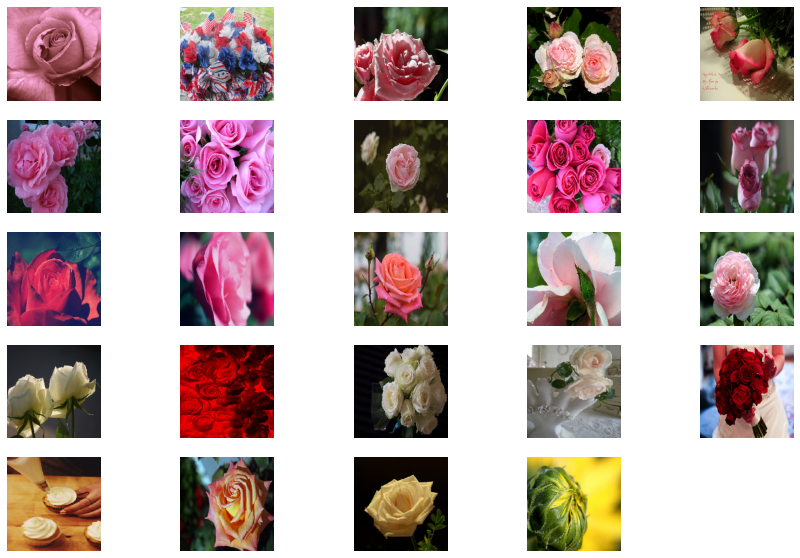

In [30]:
dict_ = print_flowers_cat(df, num= 24, label_text = ['Others', 'Roses', 'Sunflowers'])

Vemos cómo las flores se agrupan en 2 grupos de girasoles, otros 2 de rosas y uno compuesto mayoritariamente por otro tipo de imágenes.

Agrupamos las etiquetas y ponemos nombre a cada una:

In [ ]:

df["kmeans_label_name"] = df.labels_kmeans.map(dict_)

Etiqueta:  Roses
Número de imágenes:  488


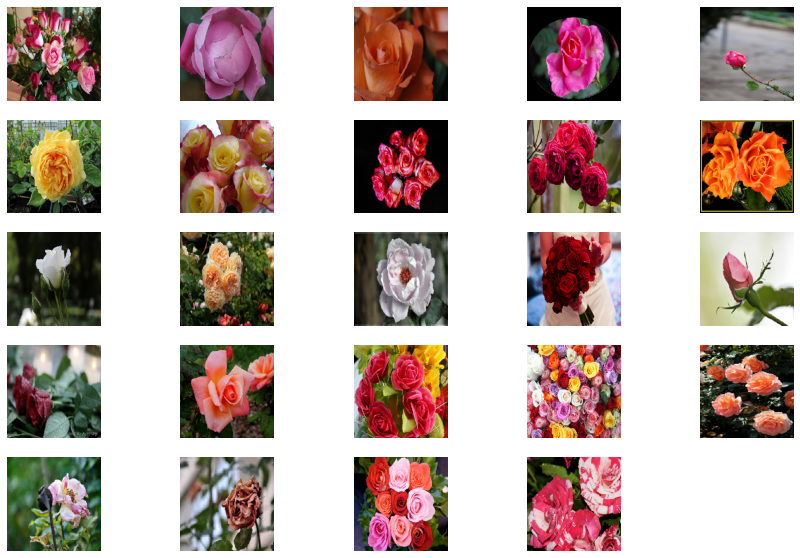

Etiqueta:  Sunflowers
Número de imágenes:  779


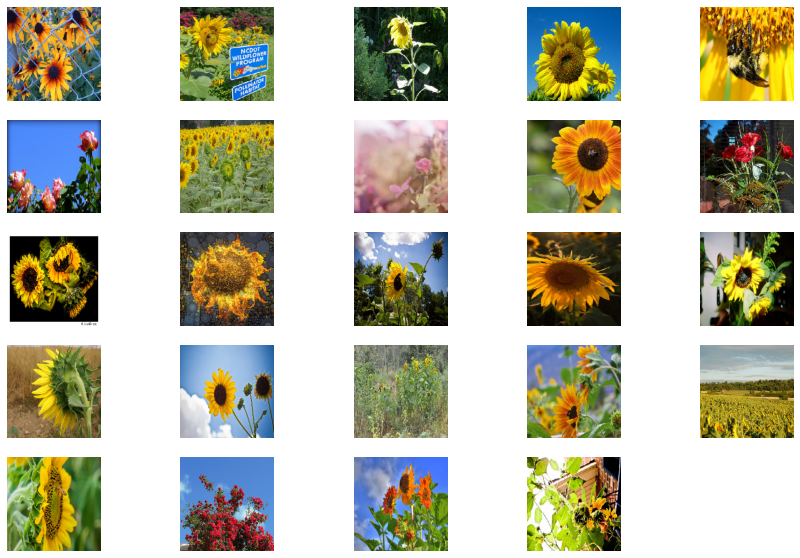

Etiqueta:  Others
Número de imágenes:  300


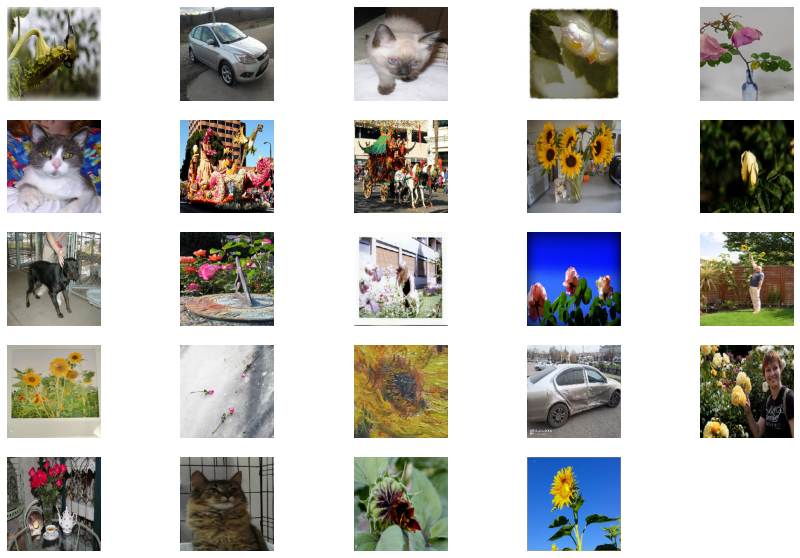

{}

In [ ]:
print_flowers_cat(df, labels='kmeans_label_name', num= 24)

# MLP
Utilizamos un Multi-layer Perceptron classifier. En este caso, como buscamos huir del overfitting montamos un clasificador con muy pocas capas.

In [ ]:
columns_dist=['dist_centroid_' + str(i) for i in range(k)]

scaler = StandardScaler()
df[pca_columns + columns_dist] = pd.DataFrame(scaler.fit_transform(df[pca_columns + columns_dist]))

In [ ]:
clf = MLPClassifier(hidden_layer_sizes=(3,), max_iter=2000)

columns_dist=['dist_centroid_' + str(i) for i in range(k)]
clf.fit(df[columns_dist + pca_columns],df['labels_kmeans'])

MLPClassifier(hidden_layer_sizes=(3,), max_iter=2000)

In [ ]:
df['labels_mplp'] = clf.predict(df[columns_dist + pca_columns])

Y la probabilidad.

In [ ]:
df['mplp_predict_proba'] = clf.predict_proba(df[columns_dist + pca_columns]).tolist()

In [ ]:

df["mlpc_label_name"] = df.labels_mplp.map(dict_)

In [ ]:
df = df.assign(mlp_predict_proba_single = df[['mplp_predict_proba', 'labels_mplp']].apply(lambda rows: rows[0][rows[1]], axis =1))

Algunas etiquetas coinciden con las del proceso de clustering pero otras no:

In [ ]:
df_diff = df[df.labels_kmeans != df.labels_mplp]

Veamos los valores superiores de la red MLPC:

In [ ]:
df_diff[['file', 'mlp_predict_proba_single']].sort_values('mlp_predict_proba_single', ascending = False).head(5)

file  mlp_predict_proba_single
944  imagen1386.jpg                  0.902773
623  imagen1359.jpg                  0.874842
726   imagen607.jpg                  0.874842
410   imagen776.jpg                  0.874842
442  imagen1411.jpg                  0.874842

Y los valores inferiores

In [ ]:
df_diff[['file', 'mlp_predict_proba_single'] ].sort_values('mlp_predict_proba_single', ascending = False).tail(5)

file  mlp_predict_proba_single
811   imagen1140.jpg                  0.521579
2      imagen884.jpg                  0.520513
1524   imagen902.jpg                  0.499544
1152   imagen829.jpg                  0.473140
1296   imagen534.jpg                  0.372005

In [ ]:
df_diff = df[df.kmeans_label_name != df.mlpc_label_name]
print("No coinciden ", df_diff.shape[0], " imágenes")


No coinciden  49  imágenes


In [ ]:
df_diff[['kmeans_label_name', 'mlpc_label_name', 'mlp_predict_proba_single']].sort_values(by=['mlp_predict_proba_single'])

kmeans_label_name mlpc_label_name  mlp_predict_proba_single
1296        Sunflowers          Others                  0.372005
1152        Sunflowers          Others                  0.473140
1524        Sunflowers          Others                  0.499544
676         Sunflowers          Others                  0.580481
897         Sunflowers          Others                  0.618951
503         Sunflowers          Others                  0.625103
488         Sunflowers          Others                  0.640745
511         Sunflowers          Others                  0.640745
789         Sunflowers          Others                  0.682967
57               Roses      Sunflowers                  0.834740
935              Roses      Sunflowers                  0.836546
924              Roses      Sunflowers                  0.837490
1149             Roses      Sunflowers                  0.838210
1205             Roses      Sunflowers                  0.838272
418              Roses      Sunflowers                  0.848320
122              Roses      Sunflowers                  0.856048
21               Roses      Sunflowers                  0.861654
768              Roses      Sunflowers                  0.863696
115              Roses      Sunflowers                  0.863815
17          Sunflowers          Others                  0.871022
500         Sunflowers          Others                  0.874842
1409        Sunflowers          Others                  0.874842
1372        Sunflowers          Others                  0.874842
1308        Sunflowers          Others                  0.874842
50          Sunflowers          Others                  0.874842
78          Sunflowers          Others                  0.874842
1188        Sunflowers          Others                  0.874842
121         Sunflowers          Others                  0.874842
149         Sunflowers          Others                  0.874842
1001        Sunflowers          Others                  0.874842
1000        Sunflowers          Others                  0.874842
161         Sunflowers          Others                  0.874842
496         Sunflowers          Others                  0.874842
927         Sunflowers          Others                  0.874842
904         Sunflowers          Others                  0.874842
247         Sunflowers          Others                  0.874842
330         Sunflowers          Others                  0.874842
344         Sunflowers          Others                  0.874842
726         Sunflowers          Others                  0.874842
410         Sunflowers          Others                  0.874842
623         Sunflowers          Others                  0.874842
578         Sunflowers          Others                  0.874842
1522        Sunflowers          Others                  0.874842
512         Sunflowers          Others                  0.874842
442         Sunflowers          Others                  0.874842
452         Sunflowers          Others                  0.874842
165         Sunflowers          Others                  0.874842
515         Sunflowers          Others                  0.874842
944              Roses      Sunflowers                  0.902773

Y su distribución

Text(0, 0.5, 'Count')

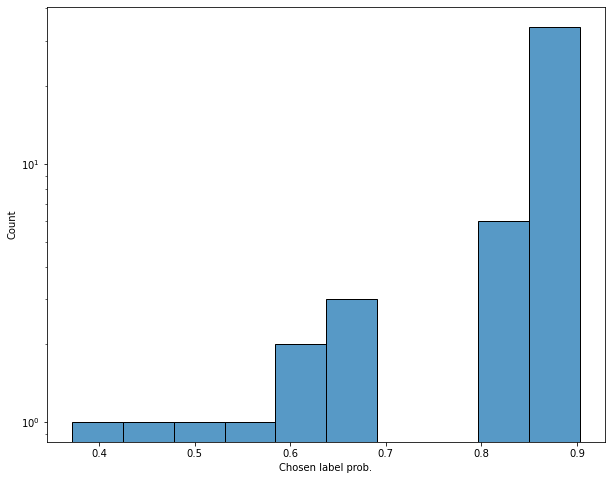

In [ ]:

plt.figure(figsize=(10,8))
plt.yscale('log')
sns.histplot(df_diff['mlp_predict_proba_single'], bins=10)
plt.xlabel("Chosen label prob.")
plt.ylabel("Count")

Veamos algunas de ellas:

In [ ]:
def print_flowers_diff(df, *args, num_examples = 9, col='image', size = (15,10)):
    """Función que imprime por consola un número imágenes aleatoriamente escogidas de un Pandas dataframe.

    Args:
        df (Pandas dataframe): Dataframe contenedor de imágenes
        num_examples (int, optional): Número de imágenes a mostrar. Defaults to 9.
        col (str, optional): Nombre de la columna que contiene las imágenes. Defaults to 'image'.
        size (tuple, optional): Tamaño de la figura que contiene las imágenes. Defaults to (15,10).
    """
    
    try:
        num_imgs_df = df.shape[0]
        num_imgs_show = min(num_examples, num_imgs_df)

        print("Número de imágenes: ", num_imgs_df)

        df_examples = df.sample(num_imgs_show).reset_index()
        gs = gridspec.GridSpec( int(np.ceil(np.sqrt(num_imgs_show))), int(np.ceil(np.sqrt(num_imgs_show))))
        gs.update(hspace = 0.75)
        plt.figure(figsize = size)

        for i in range(0, num_imgs_show):
            plt.subplot(gs[i])
            plt.imshow(df_examples.reset_index()[col][i])    
            tit = ["{}: {}".format(k,df_examples.loc[i,k]) for k in list(args)]
            plt.title('\n'.join(tit) + '\n' + str(round(df_examples.mlp_predict_proba_single[i],2)))
            plt.axis('off')
    except Exception as e:
        print("Ha surgido un problemaal imprimir")
        print(e)


Veamos las imágenes que diferencian entre uno y otro.

Número de imágenes:  49


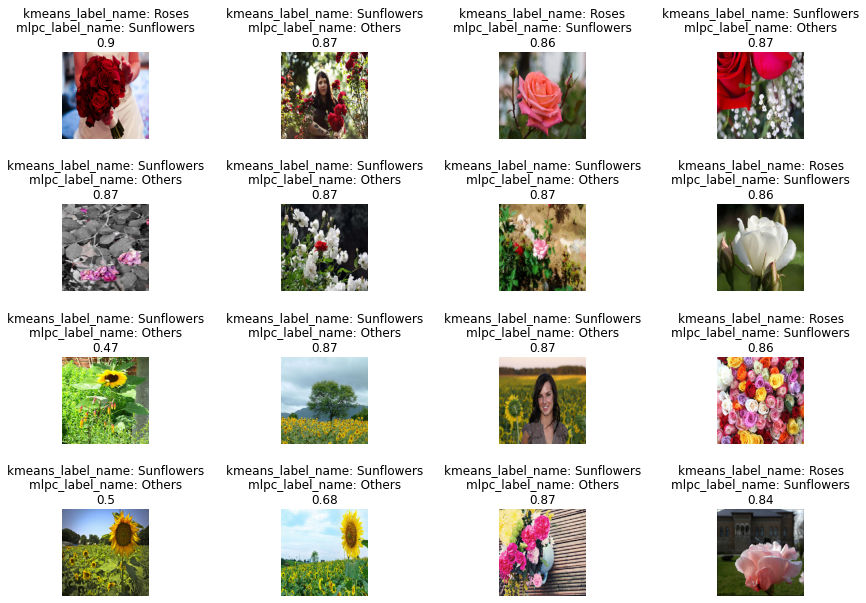

In [ ]:
df_diff_print = df_diff[['image','kmeans_label_name', 'mlpc_label_name', 'mlp_predict_proba_single']]
print_flowers_diff(df_diff_print,'kmeans_label_name', 'mlpc_label_name', num_examples = 16)

Almacenamos la probabilidad con la que el Clsificador a elegido cada imagen

In [ ]:
df = df.assign(mlp_predict_proba_single = df[['mplp_predict_proba', 'labels_mplp']].apply(lambda rows: rows[0][rows[1]], axis =1))

In [ ]:
def decide_label(row, th=0.5):
    """Función que utilizaremos para determinar la etiqueta final. 

    Args:
        row (PD Serie: Fila compuesta por ['labels_kmeans', 'labels_mplp', 'mlp_predict_proba_single']
        th (float, optional): Umbral para considerar si mantener la etiqueta del K means o el Clasificador. Defaults to 0.3.

    Returns:
        int : Etiqueta decidida.
    """
    if row[0] == row[1] or row[2] > th:
        return row[1]
    else:
        return row[0]
    

df = df.assign(label= df[['kmeans_label_name', 'mlpc_label_name', 'mlp_predict_proba_single']].apply(lambda rows: decide_label(rows, th=0.7), axis = 1 ))

Número de imágenes:  49


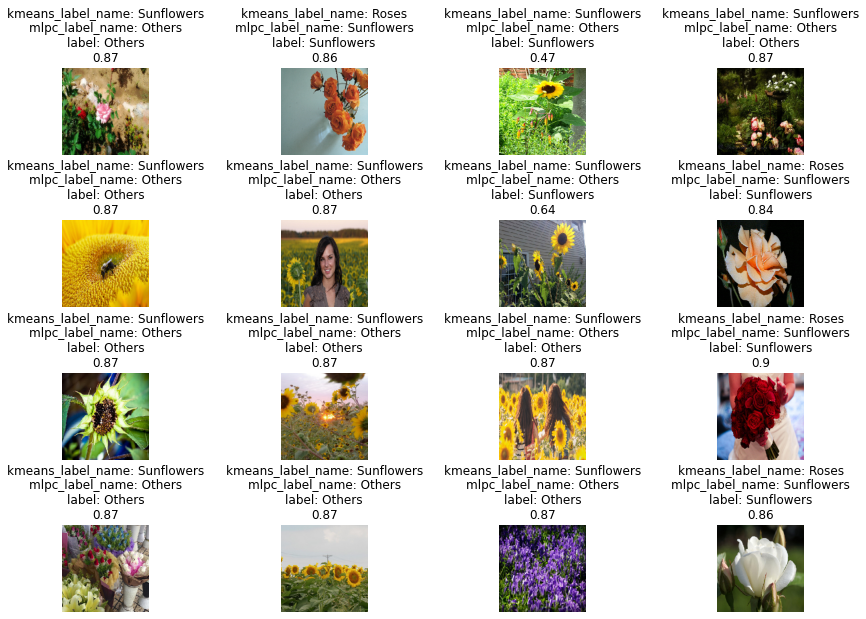

In [ ]:
df_diff = df[df.kmeans_label_name != df.mlpc_label_name]
df_diff_print = df_diff[['image','kmeans_label_name', 'mlpc_label_name', 'mlp_predict_proba_single','label']]
print_flowers_diff(df_diff_print,'kmeans_label_name', 'mlpc_label_name','label', num_examples = 16)

En esta imagen podemos ver algunos ejemplos del refinamiento. Las imagenes con etiquetas diferentes en las que la probaibilidad del mlpc es mayor que el umbral se corrigen.

En la siguiente gráfica podemos ver cómo se han distribuido las etiquetas

Text(0, 0.5, 'count')

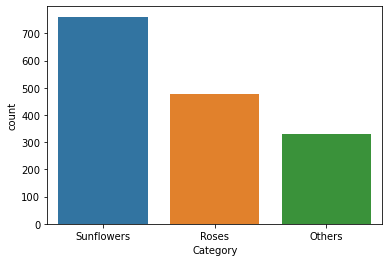

In [ ]:
sns.countplot(data = df, x='label', order = df['label'].value_counts().index)
plt.xlabel("Category")
plt.ylabel("count")

En la siguiente gráfica podemos ver cuál ha sido la probabilidad que se ha dado para la etiqueta elegida

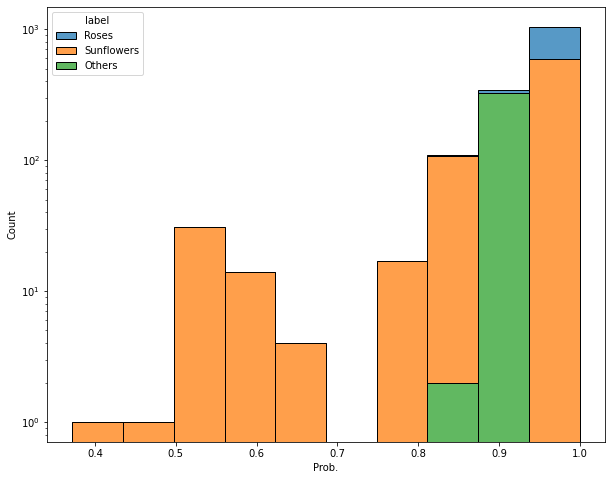

In [ ]:
plt.figure(figsize=(10,8))
sns.histplot(df,x='mlp_predict_proba_single',hue='label', multiple='stack', bins=10)
plt.ylabel("Count")
plt.xlabel("Prob.")
plt.yscale('log')

En esta gráfica vemos como se distribuye las imágenes en función de la probabilidad resultante de MLPC. Las agrupamos por etiquetas. 

Por último guardamos las imágenes por carpetas con la fecha y hora del momento en que se ejecutó:



In [ ]:
def save_img_cat_folder(df, folder,  labels= 'label'):
    date_time = datetime.now().strftime("%d%m%Y%H%M%S")
    dir_= os.path.join('./',folder + date_time)
    
    os.mkdir(dir_)
    
    for l in df[labels].unique():
        dir_cat= os.path.join(dir_,str(l))
        os.mkdir(dir_cat)

        files_paths = df[df[labels] == l ].path.tolist()
        files_names = df[df[labels] == l ].file.tolist()

        for origin_path, f_name in zip(files_paths, files_names):
            dir_dest = os.path.join(dir_cat, f_name)
            shutil.copy(origin_path, dir_dest)

In [ ]:
save_img_cat_folder(df, 'Label Sunflower vs Roses',  labels= 'label')
